In [1]:
import time

import numpy as np
import pandas as pd

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.lut import make_lut_node
from architecture.nodes.ripper import make_ripper_node

In [2]:
train_df = pd.read_csv("./data/mnist/mnist_train.csv")
test_df = pd.read_csv("./data/mnist/mnist_test.csv")

input_values_train = train_df.drop(columns="label").to_numpy(bool)
target_values_train = train_df["label"].to_numpy(bool)

input_values_test = test_df.drop(columns="label").to_numpy(bool)
target_values_test = test_df["label"].to_numpy(bool)

print("Dataset shapes:")
print(f"TRAIN | input: {input_values_train.shape}, target: {target_values_train.shape}, pos. frac.: {target_values_train.mean():.3f}")
print(f"TEST  | input: {input_values_test.shape}, target: {target_values_test.shape}, pos. frac.: {target_values_test.mean():.3f}")

Dataset shapes:
TRAIN | input: (10000, 196), target: (10000,), pos. frac.: 0.486
TEST  | input: (1500, 196), target: (1500,), pos. frac.: 0.497


In [3]:
def run_variable_node_experiment(
        node_factory,
        input_values_train,
        target_values_train,
        input_values_test,
        target_values_test,
        hidden_layer_count: int,
        layer_node_counts: list[int],
        layer_bit_count: int,
        output_node_count: int = 1,         # we have the possibility to smoothen over multiple output nodes
        seed: int = 42,
        jobs: int | None = None
):
    train_accs, test_accs = [], []

    for layer_node_count in layer_node_counts:
        start = time.perf_counter()

        net = DeepBinaryClassifier(
            layer_node_counts=[layer_node_count] * hidden_layer_count + [output_node_count],
            layer_bit_counts=[layer_bit_count] * (hidden_layer_count + 1),
            node_factory=node_factory,
            seed=seed,
            jobs=jobs
        )
        net.fit(input_values_train, target_values_train)

        duration = time.perf_counter() - start

        pred_values_train = net.predict(input_values_train)
        pred_values_test  = net.predict(input_values_test)

        # broadcast reference targets and compute accuracies
        ref_values_train = np.broadcast_to(target_values_train[:, None], pred_values_train.shape)
        ref_values_test  = np.broadcast_to(target_values_test[:, None], pred_values_test.shape)
        train_node_accs = (pred_values_train == ref_values_train).mean(axis=0)
        test_node_accs  = (pred_values_test == ref_values_test).mean(axis=0)

        train_accs.append(train_node_accs.mean())
        test_accs.append(test_node_accs.mean())

        print(f"{layer_node_count:>5} nodes/layer | train {train_accs[-1]:.2f}"
              f"| test {test_accs[-1]:.2f} | time {duration:.2f}s")

    return train_accs, test_accs

In [4]:
# experiment setup
hidden_layer_count = 4
layer_node_counts  = [4, 8, 16, 32, 64, 128, 256]
layer_bit_count    = 4

In [5]:
lut_train_acc, lut_test_acc = run_variable_node_experiment(
    node_factory=make_lut_node,
    input_values_train=input_values_train,
    target_values_train=target_values_train,
    input_values_test=input_values_test,
    target_values_test=target_values_test,
    hidden_layer_count=hidden_layer_count,
    layer_node_counts=layer_node_counts,
    layer_bit_count=layer_bit_count,
    output_node_count=10,
    seed=42
)

    4 nodes/layer | train 0.64| test 0.63 | time 0.01s
    8 nodes/layer | train 0.63| test 0.64 | time 0.01s
   16 nodes/layer | train 0.74| test 0.74 | time 0.02s
   32 nodes/layer | train 0.74| test 0.72 | time 0.03s
   64 nodes/layer | train 0.78| test 0.79 | time 0.06s
  128 nodes/layer | train 0.79| test 0.79 | time 0.13s
  256 nodes/layer | train 0.79| test 0.78 | time 0.24s


In [6]:
ripper_train_acc, ripper_test_acc = run_variable_node_experiment(
    node_factory=make_ripper_node,
    input_values_train=input_values_train,
    target_values_train=target_values_train,
    input_values_test=input_values_test,
    target_values_test=target_values_test,
    hidden_layer_count=hidden_layer_count,
    layer_node_counts=layer_node_counts,
    layer_bit_count=layer_bit_count,
    output_node_count=10,
    seed=42,
    jobs=8
)

    4 nodes/layer | train 0.64| test 0.62 | time 6.51s
    8 nodes/layer | train 0.64| test 0.63 | time 11.69s
   16 nodes/layer | train 0.73| test 0.73 | time 16.88s
   32 nodes/layer | train 0.73| test 0.72 | time 21.79s
   64 nodes/layer | train 0.78| test 0.79 | time 37.26s
  128 nodes/layer | train 0.78| test 0.78 | time 72.38s
  256 nodes/layer | train 0.79| test 0.79 | time 142.46s


In [7]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False
})

def plot_variable_node_results(layer_node_counts, lut_train, lut_test, ripper_train, ripper_test, dpi: int = 120):
    lut_color = "#a24a55"
    ripper_color = "#2e5f7f"
    face_color = "white"

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=dpi, facecolor=face_color, sharey=True)
    for ax in axes:
        ax.set_facecolor(face_color)

        # style the y-axis
        y_ticks = np.linspace(0.6, 0.8, 6)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f"${t:.2f}$" for t in y_ticks])
        ax.set_ylim(0.6, 0.8)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(alpha=0.3, linewidth=0.8)

    axes[0].plot(layer_node_counts, lut_train, marker="s", color=lut_color, label=r"$\text{LUT}$")
    axes[0].plot(layer_node_counts, ripper_train, marker="s", color=ripper_color, label=r"$\text{RIPPER}$")
    axes[0].set_title(r"$\text{Training Accuracy}$", fontsize=16)
    axes[0].set_xlabel(r"$\text{nodes per hidden layer}$", fontsize=14)
    axes[0].set_ylabel(r"$\text{accuracy}$", fontsize=14)
    axes[0].set_xscale("log", base=2)
    axes[0].legend(frameon=True, framealpha=1, fontsize=14, loc="lower right")

    axes[1].plot(layer_node_counts, lut_test, marker="s", color=lut_color, label=r"$\text{LUT}$")
    axes[1].plot(layer_node_counts, ripper_test, marker="s", color=ripper_color, label=r"$\text{RIPPER}$")
    axes[1].set_title(r"$\text{Test Accuracy}$", fontsize=16)
    axes[1].set_xlabel(r"$\text{nodes per hidden layer}$", fontsize=14)
    axes[1].set_xscale("log", base=2)
    axes[1].legend(frameon=True, framealpha=1, fontsize=14, loc="lower right")

    plt.tight_layout()
    return fig, axes

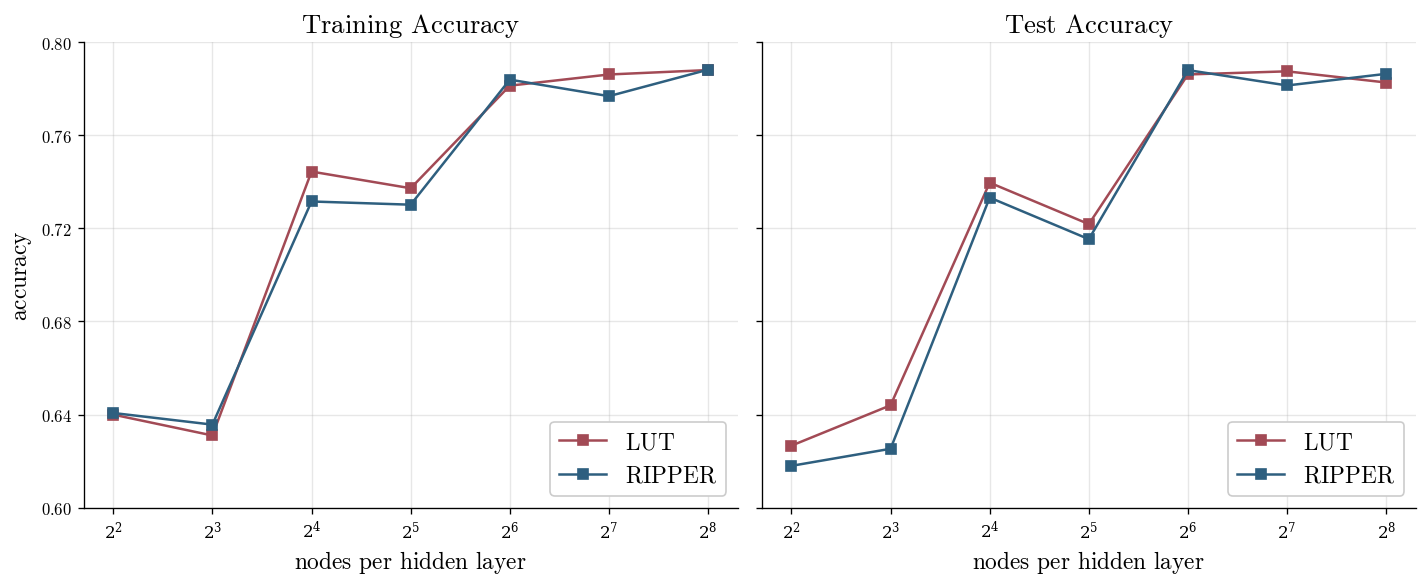

In [8]:
fig, axes = plot_variable_node_results(layer_node_counts, lut_train_acc, lut_test_acc,
                                       ripper_train_acc, ripper_test_acc)
plt.show()

In [9]:
fig.savefig("./figures/mnist_node_count_comparison.png", dpi=300)